# Enhanced Deep Residual Networks for single-image super-resolution

## Introduction

In this example, we implement
[Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR)](https://arxiv.org/abs/1707.02921)
by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, and Kyoung Mu Lee.

The EDSR architecture is based on the SRResNet architecture and consists of multiple
residual blocks. It uses constant scaling layers instead of batch normalization layers to
produce consistent results (input and output have similar distributions, thus
normalizing intermediate features may not be desirable). Instead of using a L2 loss (mean squared error),
the authors employed an L1 loss (mean absolute error), which performs better empirically.

Our implementation only includes 16 residual blocks with 64 channels.

Alternatively, as shown in the Keras example
[Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/#image-superresolution-using-an-efficient-subpixel-cnn),
you can do super-resolution using an ESPCN Model. According to the survey paper, EDSR is one of the top-five
best-performing super-resolution methods based on PSNR scores. However, it has more
parameters and requires more computational power than other approaches.
It has a PSNR value (≈34db) that is slightly higher than ESPCN (≈32db).
As per the survey paper, EDSR performs better than ESPCN.

Comparison Graph:
<img src="https://dfzljdn9uc3pi.cloudfront.net/2021/cs-621/1/fig-11-2x.jpg" width="500" />

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

import pickle
import os

from src.edsr import train_model, build_model

AUTOTUNE = tf.data.AUTOTUNE

2025-11-05 22:33:11.158381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the training dataset

We use the DIV2K Dataset, a prominent single-image super-resolution dataset with 1,000
images of scenes with various sorts of degradations,
divided into 800 images for training, 100 images for validation, and 100
images for testing. We use 4x bicubic downsampled images as our "low quality" reference.

In [2]:
from src.data import load_data
train, val, train_cache, val_cache = load_data()

I0000 00:00:1762378361.521275  185869 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Preprocessing

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 24x24 RGB input patches.

In [3]:
from src.preprocessing import preprocess

train_ds, val_ds = preprocess(train_cache, val_cache)

### Some plots

2025-11-05 20:42:26.535553: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


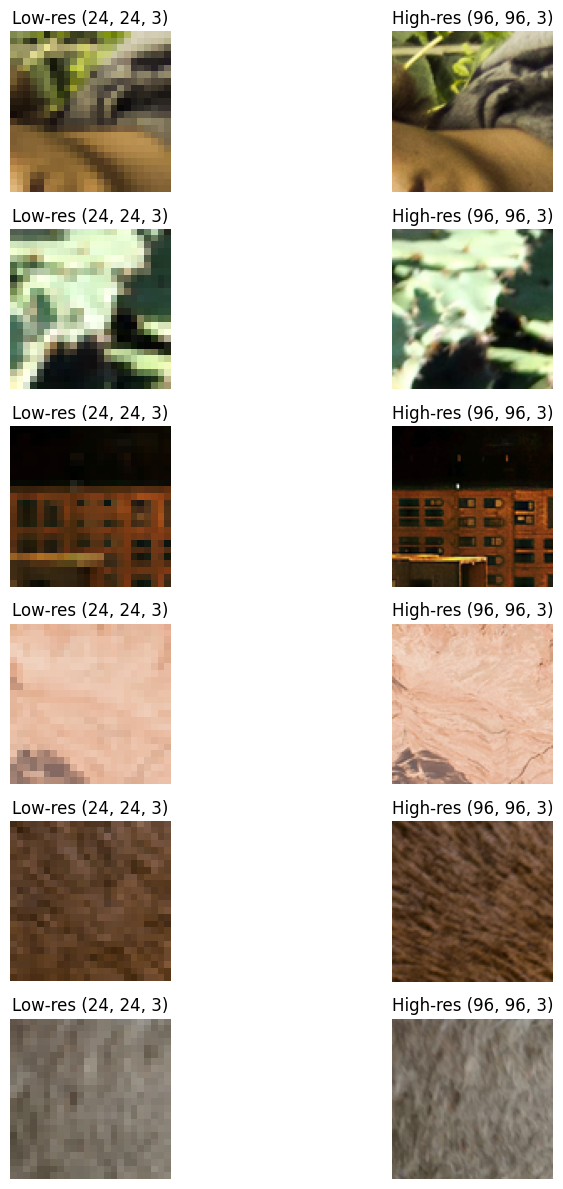

In [5]:
lowres, highres = next(iter(train_ds))

n = 6
plt.figure(figsize=(10, n * 2))

for i in range(n):
    ax = plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(f"Low-res {lowres[i].shape}")
    plt.axis("off")

    ax = plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(f"High-res {highres[i].shape}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

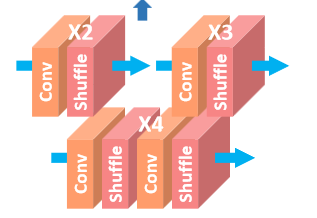

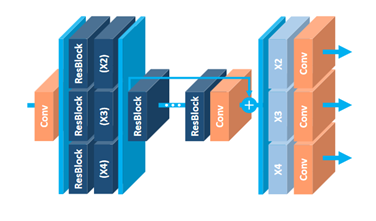

We wrap all the code inside standardize modules ready for usage:

```
src
├── data.py
├── edsr.py
├── loss.py
├── preprocessing.py
└── utils.py
```

### Conversion YUV <-> PNG for video processing

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image

def yuv420_to_png(yuv_file, width, height, num_frames, output_dir_png):
    # Check if the directory exists
    if os.path.exists(output_dir_png):
        # If it exists, delete it
        shutil.rmtree(output_dir_png)
        print(f"Created directory {output_dir_png}")

    # Create a new directory
    os.makedirs(output_dir_png)

    # Open the YUV file
    with open(yuv_file, "rb") as file:
        frame_size = width * height * 3 // 2  # YUV420p has 1.5 bytes per pixel

        for i in range(num_frames):
            # Read the Y, U, and V components
            y = np.frombuffer(file.read(width * height), dtype=np.uint8).reshape((height, width))
            u = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))
            v = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))

            # Upsample U and V to match the Y plane size
            u_up = u.repeat(2, axis=0).repeat(2, axis=1)
            v_up = v.repeat(2, axis=0).repeat(2, axis=1)

            # Combine Y, U, V into an RGB image
            yuv = np.stack((y, u_up, v_up), axis=-1)
            rgb = Image.fromarray(yuv, "YCbCr").convert("RGB")

            # Save the frame as a PNG file
            png_filename = os.path.join(output_dir_png, f"frame_{i:04d}.png")
            rgb.save(png_filename)


def png_to_yuv420(input_dir, num_frames):
    # Directory path for the output
    output_dir = os.path.join(os.path.dirname(input_dir), "YUV")

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f'Directory {output_dir} created.')

    # Get the list of PNG files, sorted by frame order
    png_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])[:num_frames]

    # Determine the size of the images
    sample_image = Image.open(os.path.join(input_dir, png_files[0]))
    width, height = sample_image.size

    # Open a YUV file to write the frames into
    yuv_filename = os.path.join(output_dir, f"output_{width}x{height}_{num_frames}_420.yuv")
    with open(yuv_filename, "wb") as yuv_file:
        for i, png_file in enumerate(png_files):
            img = Image.open(os.path.join(input_dir, png_file)).convert("YCbCr")
            y, u, v = img.split()

            # Downsample U and V to 1/4 resolution
            u = u.resize((width // 2, height // 2), Image.Resampling.NEAREST)
            v = v.resize((width // 2, height // 2), Image.Resampling.NEAREST)

            # Write Y, U, and V planes to the YUV file
            yuv_file.write(y.tobytes())
            yuv_file.write(u.tobytes())
            yuv_file.write(v.tobytes())
            print(f'File {i} done')
        print(f'YUV stored at {output_dir}')

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You could improve the model accuracy by training the model for more epochs, as well as
training the model with a wider variety of inputs with mixed downgrading factors, so as to
be able to handle a greater range of real-world images.

You could also improve on the given baseline EDSR model by implementing EDSR+,
or MDSR( Multi-Scale super-resolution) and MDSR+,
which were proposed in the same paper.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-EDSR-red.svg)](https://huggingface.co/keras-io/EDSR) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-EDSR-red.svg)](https://huggingface.co/spaces/keras-io/EDSR) |

# Running experiments

## Experiment - [10, 20, 30, 50, 100] - PSNR - 2 scale factor - 64 Filters, 16 Blocks

### Training

In [9]:
model = build_model(num_filters=64, num_res_blocks=16, scale=4, loss="mae", metric="both")
model, history = train_model(model, train_ds, val_ds, epochs=100, scale=2, saving_epochs=[10, 20, 30, 50, 100]) # ssim & psnr

Epoch 1/100


2025-11-05 21:31:31.081065: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-11-05 21:31:31.081145: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert


200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - psnr: 19.2747 - ssim: 0.3240 - loss: 0.0000e+00 - val_loss: 14.7473 - val_psnr: 23.0047 - val_ssim: 0.4890
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 24.8132 - ssim: 0.5761 - loss: 0.0000e+00 - val_loss: 10.6585 - val_psnr: 25.6929 - val_ssim: 0.6159
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - psnr: 26.1154 - ssim: 0.6457 - loss: 0.0000e+00 - val_loss: 10.7871 - val_psnr: 25.7852 - val_ssim: 0.6297
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 26.9593 - ssim: 0.6819 - loss: 0.0000e+00 - val_loss: 9.7587 - val_psnr: 27.0335 - val_ssim: 0.6865
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 27.7613 - ssim: 0.7084 - loss: 0.0000e+00 - val_loss: 9.7164 - val_psnr: 27.5256 - val_ssim: 0.7142
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 28.0181 - ssim: 0.7199 - loss: 0.0000e+00 - val_loss: 7.9491 - val_psnr: 28.8783 - val_ssim: 0.7368
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━

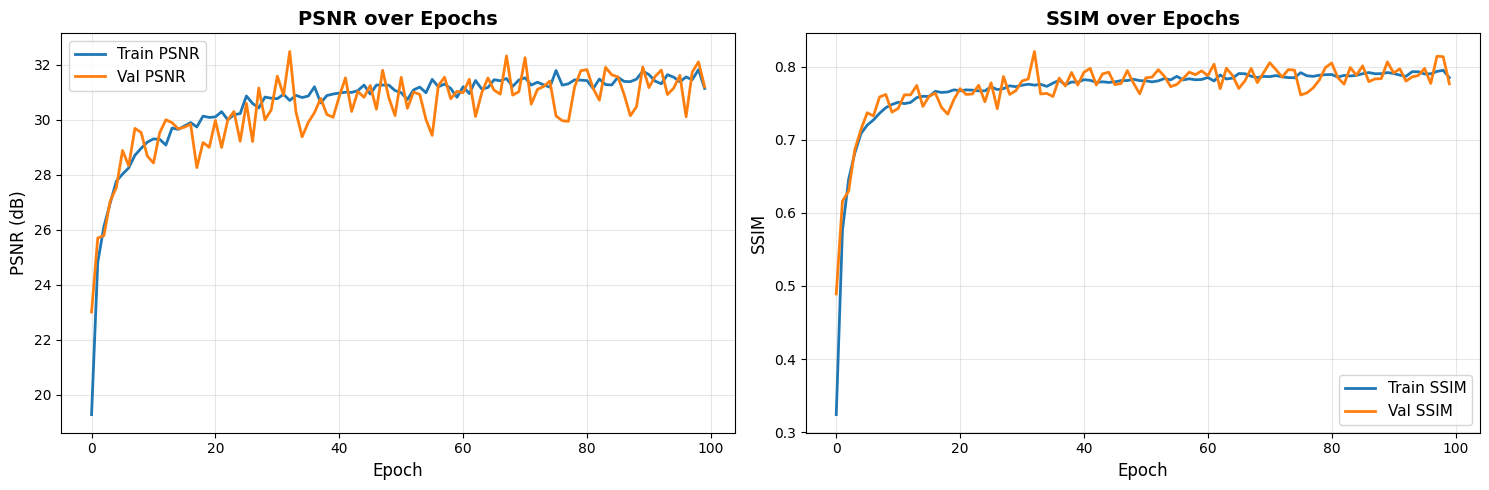


Final Training Metrics:
Train PSNR: 31.1337 dB
Val PSNR:   31.1888 dB
Train SSIM: 0.7849
Val SSIM:   0.7766


In [10]:
from src.utils import plot_training_history
plot_training_history(history)

### Testing

/home/forge/ml-video-compression/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 145 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-11-04 13:57:51.633095: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


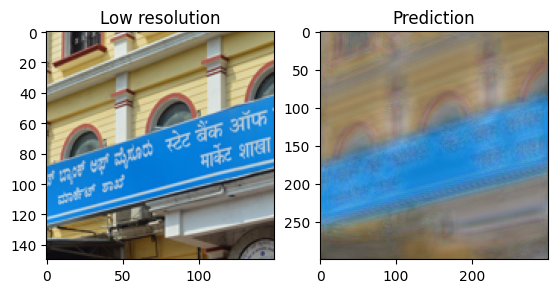

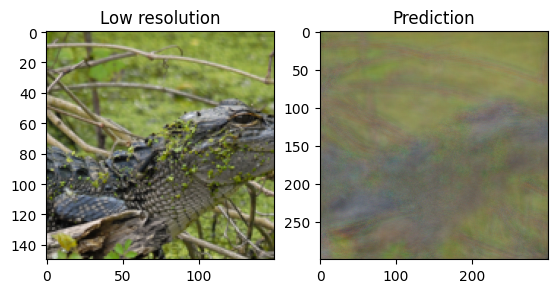

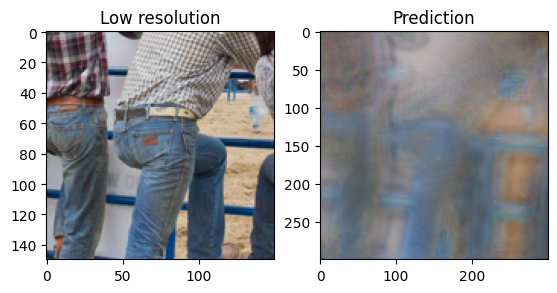

2025-11-04 13:57:54.001087: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
from src.utils import plot_results
from src.edsr import build_model
import tensorflow as tf

model = build_model(num_filters=64, num_res_blocks=16, scale=2)
model.load_weights("weights/weights_psnr_30epochs_2scale.weights.h5")

for lowres, highres in val.take(3):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)
    exit(0)

### Testing on real world video

Executing outside that notebook

```bash
python3 src/video_pipeline/batch_process.py --weights weights/2scale/weights_psnr_100epochs_2scale.weights.h5 --source-dir source/ --output-csv results/4scale/results_100_epochs_4_scale.csv

python3 src/video_pipeline/plot_psnr_epochs.py
```

![performance](./assets/psnr_all_videos_vs_epochs_scale_2.png)

------------

## Experiment - [10, 20, 30, 50, 100] epochs - PSNR / SSIM - 4 scale factor - 64 Filters, 16 Blocks

### Training

In [4]:
model = build_model(num_filters=64, num_res_blocks=16, scale=4, loss="mae", metric="both")
model, history = train_model(model, train_ds, val_ds, epochs=100, scale=4, saving_epochs=[10, 20, 30, 50, 100]) # ssim & psnr

Epoch 1/100


/home/forge/ml-video-compression/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py:695: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
2025-11-05 21:14:22.167756: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-05 21:14:23.823805: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ffe18001f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 21:14:23.823844: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-05 21:14:24.768875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-05 2

  5/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - psnr: 3.9526 - ssim: 0.0290 - loss: 0.0000e+00

I0000 00:00:1762373672.202861   76515 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - psnr: 16.0738 - ssim: 0.2060 - loss: 0.0000e+00

2025-11-05 21:15:16.603312: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-11-05 21:15:16.603480: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-11-05 21:15:16.605051: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-05 21:15:16.605205: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-05 21:15:16.605548: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-05 21:15:16.605717: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-05 21:15:17.953449: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-11-05 21:15:17.953480: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSN

200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 234ms/step - psnr: 19.8553 - ssim: 0.3361 - loss: 0.0000e+00 - val_loss: 15.5732 - val_psnr: 22.4065 - val_ssim: 0.4589
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 24.6486 - ssim: 0.5692 - loss: 0.0000e+00 - val_loss: 10.4678 - val_psnr: 25.7115 - val_ssim: 0.6250
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 26.2305 - ssim: 0.6494 - loss: 0.0000e+00 - val_loss: 10.3460 - val_psnr: 26.1922 - val_ssim: 0.6394
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 27.1106 - ssim: 0.6862 - loss: 0.0000e+00 - val_loss: 8.8627 - val_psnr: 27.2115 - val_ssim: 0.6942
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - psnr: 27.8332 - ssim: 0.7118 - loss: 0.0000e+00 - val_loss: 8.7267 - val_psnr: 28.4172 - val_ssim: 0.7427
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - psnr: 28.1634 - ssim: 0.7218 - loss: 0.0000e+00 - val_loss: 8.3791 - val_psnr: 28.3480 - val_ssim: 0.7228
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━

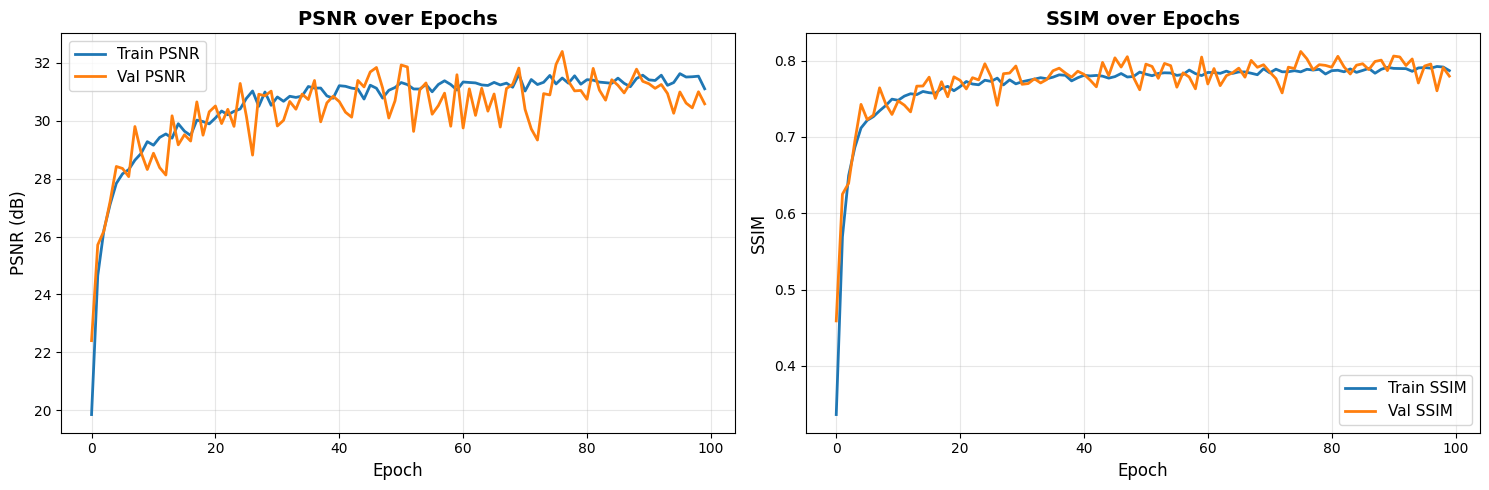


Final Training Metrics:
Train PSNR: 31.0972 dB
Val PSNR:   30.5777 dB
Train SSIM: 0.7870
Val SSIM:   0.7798


In [8]:
from src.utils import plot_training_history

plot_training_history(history)

### Testing

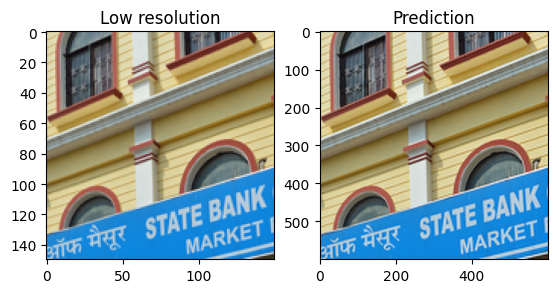

hi


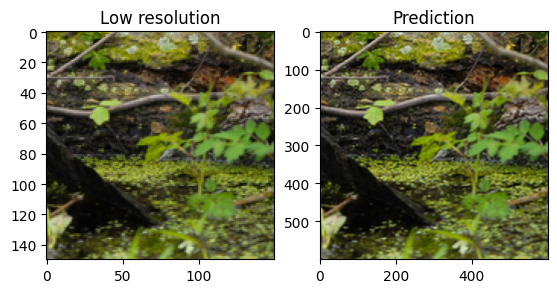

hi


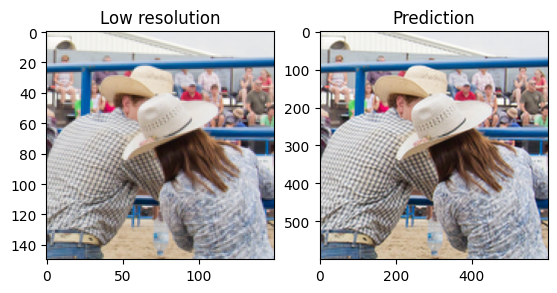

hi


2025-11-04 13:56:05.366597: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
from src.edsr import build_model
from src.utils import plot_results

model = build_model(num_filters=64, num_res_blocks=16, scale=4)
model.load_weights('weights/4scale/weights_both_100epochs_4scale.weights.h5')

for lowres, highres in val.take(3):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)
    exit(0)

### Performance on real world videos

Executing outside that notebook

```bash
python3 src/video_pipeline/batch_process.py --weights weights/weights_psnr_20epochs_4scale.weights.h5 --source-dir source/ --output-csv results/results_100_epochs_4_scale.csv

python3 src/video_pipeline/plot_psnr_epochs.py
```

![performance](./assets/psnr_all_videos_vs_epochs_scale_4.png)

## Experiment - [10, 20, 30, 50, 100] epochs - PSNR - 8 scale factor - 64 Filters, 16 Blocks

### Loading x8

In [1]:
from src.data import load_data
from src.preprocessing import preprocess
train, val, train_cache, val_cache = load_data("div2k/bicubic_x8")
train_ds, val_ds = preprocess(train_cache, val_cache, scale=8, hr_crop_size=192, batch_size=8)

2025-11-05 22:41:30.141259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1762378893.746360  196020 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Training

In [2]:
from src.edsr import train_model, build_model # loading train and build code

In [3]:
model = build_model(num_filters=64, num_res_blocks=16, scale=8, loss="mae", metric="both")
model, history = train_model(model, train_ds, val_ds, epochs=100, scale=8, saving_epochs=[10, 20, 30, 50, 100]) # ssim & psnr

Epoch 1/100


/home/forge/ml-video-compression/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py:695: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
2025-11-05 22:41:57.807407: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-05 22:41:58.573834: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ffe20009720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 22:41:58.573856: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-05 22:41:59.845701: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-05 2

  3/200 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - psnr: 1.3556 - ssim: 0.0012 - loss: 0.0000e+00          

I0000 00:00:1762378929.804298  197972 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - psnr: 14.5730 - ssim: 0.1641 - loss: 0.0000e+00

/home/forge/ml-video-compression/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py:670: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
2025-11-05 22:42:24.034794: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-11-05 22:42:24.039415: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-11-05 22:42:24.041141: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-05 22:42:24.041343: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-05 22:42:24.041693: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-05 22:42:24.041872: W tensorflow/compiler/tf2xla/ke

200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - psnr: 21.3111 - ssim: 0.4119 - loss: 0.0000e+00 - val_loss: 103.6861
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - psnr: 22.3603 - ssim: 0.4828 - loss: 0.0000e+00 - val_loss: 104.7328
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 23.0684 - ssim: 0.5218 - loss: 0.0000e+00 - val_loss: 95.9739
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 23.3383 - ssim: 0.5277 - loss: 0.0000e+00 - val_loss: 112.7504
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 24.3128 - ssim: 0.5614 - loss: 0.0000e+00 - val_loss: 101.2976
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 24.8235 - ssim: 0.6147 - loss: 0.0000e+00 - val_loss: 112.8228
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 24.0481 - ssim: 0.5901 - loss: 0.0000e+00 - val_loss: 110.5528
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - psnr: 25.0706 - ssim: 0.5953 - loss: 0.0000e+00 - val_loss: 108.7766
Epoch 9/100


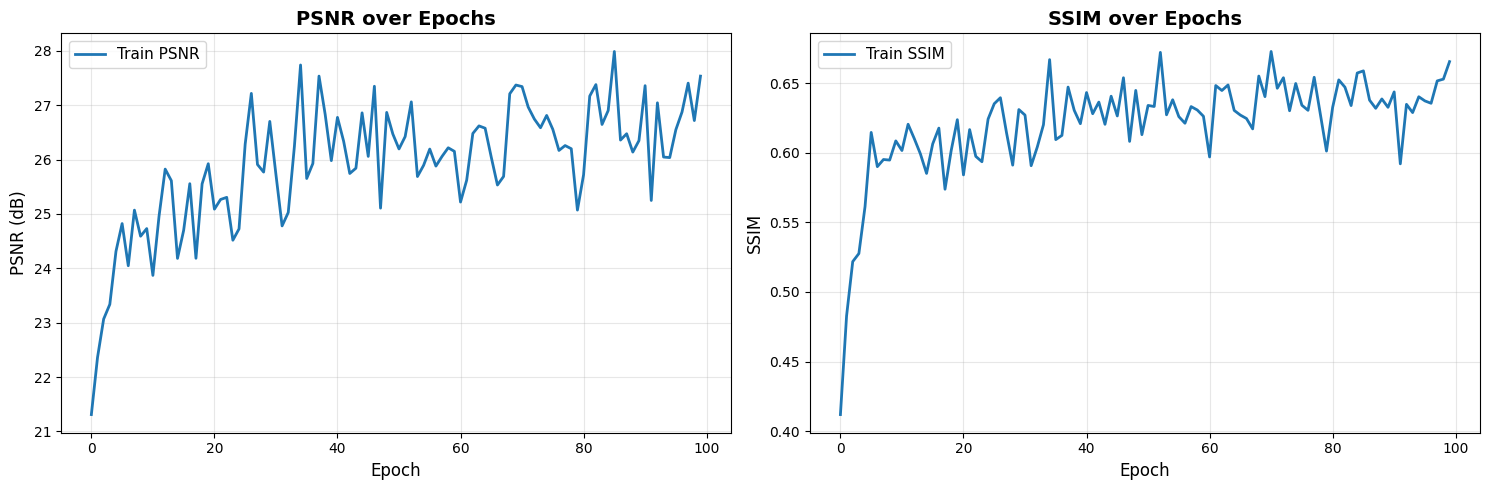


Final Training Metrics:
Train PSNR: 27.5353 dB
Train SSIM: 0.6657


In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'psnr' in history.history:
    axes[0].plot(history.history['psnr'], label='Train PSNR', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('PSNR (dB)', fontsize=12)
    axes[0].set_title('PSNR over Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

if 'ssim' in history.history:
    axes[1].plot(history.history['ssim'], label='Train SSIM', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('SSIM', fontsize=12)
    axes[1].set_title('SSIM over Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("Final Training Metrics:")
print("="*50)
if 'psnr' in history.history:
    print(f"Train PSNR: {history.history['psnr'][-1]:.4f} dB")
if 'ssim' in history.history:
    print(f"Train SSIM: {history.history['ssim'][-1]:.4f}")
print("="*50)